In [6]:
import pandas as pd
import requests
import sqlite3
import seaborn as sns
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
conn = sqlite3.connect("database.sqlite")
cur = conn.cursor()

In [141]:
cur.execute("""
            SELECT m.HomeTeam, m.AwayTeam, m.Match_ID, m.FTHG, m.FTAG, m.FTR, ut.TeamName, m.Date
            FROM Matches AS m
            JOIN Teams_In_Matches AS tim
            USING(Match_ID)
            JOIN Unique_Teams as ut
            USING(Unique_Team_ID)
            WHERE Season = 2011
""")
matches = pd.DataFrame(cur.fetchall())
matches.columns = [x[0] for x in cur.description]
matches.head(20)

,HomeTeam,AwayTeam,Match_ID,FTHG,FTAG,FTR,TeamName,Date
0,Nurnberg,Bayern Munich,1092,0,1,A,Bayern Munich,2012-03-31
1,Nurnberg,Bayern Munich,1092,0,1,A,Nurnberg,2012-03-31
2,Stuttgart,Bayern Munich,1093,1,2,A,Bayern Munich,2011-12-11
3,Stuttgart,Bayern Munich,1093,1,2,A,Stuttgart,2011-12-11
4,Wolfsburg,Bayern Munich,1094,0,1,A,Bayern Munich,2011-08-13
5,Wolfsburg,Bayern Munich,1094,0,1,A,Wolfsburg,2011-08-13
6,Mainz,Bayern Munich,1095,3,2,H,Bayern Munich,2011-11-27
7,Mainz,Bayern Munich,1095,3,2,H,Mainz,2011-11-27
8,Freiburg,Bayern Munich,1096,0,0,D,Bayern Munich,2012-02-18
9,Freiburg,Bayern Munich,1096,0,0,D,Freiburg,2012-02-18


In [142]:
match = matches.sort_values("Date")

In [143]:
match.head()

,HomeTeam,AwayTeam,Match_ID,FTHG,FTAG,FTR,TeamName,Date
150,Greuther Furth,Ein Frankfurt,1167,2,3,A,Ein Frankfurt,2011-07-15
151,Greuther Furth,Ein Frankfurt,1167,2,3,A,Greuther Furth,2011-07-15
83,Cottbus,Dresden,1133,2,1,H,Dresden,2011-07-15
82,Cottbus,Dresden,1133,2,1,H,Cottbus,2011-07-15
918,Frankfurt FSV,Union Berlin,1551,1,1,D,Union Berlin,2011-07-15


In [144]:
match.tail()

,HomeTeam,AwayTeam,Match_ID,FTHG,FTAG,FTR,TeamName,Date
1966,Everton,Newcastle,44866,3,1,H,Newcastle,2012-05-13
1965,Chelsea,Blackburn,44865,2,1,H,Blackburn,2012-05-13
1964,Chelsea,Blackburn,44865,2,1,H,Chelsea,2012-05-13
1972,Stoke,Bolton,44869,2,2,D,Bolton,2012-05-13
1983,Wigan,Wolves,44874,3,2,H,Wigan,2012-05-13


In [55]:
away = """
SELECT
    Match_ID,
    AwayTeam as TeamName,
    Date,
    -- sum(FTAG) as Goals,
    -- FTR as Results
    COUNT(FTR == "A") as Results
FROM MATCHES
WHERE Season = 2011
GROUP BY TeamName
"""
home = """
SELECT
    Match_ID,
    HomeTeam as TeamName,
    Date,
    -- sum(FTHG) as Goals,
    -- FTR as Results
    COUNT(FTR == "H") as Results
FROM MATCHES
WHERE Season = 2011
GROUP BY TeamName
"""
AWAY = pd.read_sql(away, conn)
AWAY = pd.DataFrame(AWAY)

HOME = pd.read_sql(home, conn)
HOME = pd.DataFrame(HOME)



In [51]:
home_away = HOME.append(AWAY).groupby('TeamName').agg('sum')
#home_away = HOME.append(AWAY).groupby('TeamName').sum()
home_away.head()

,Match_ID,Goals
TeamName,,
Aachen,2672,30
Arsenal,89002,74
Aston Villa,89001,37
Augsburg,2725,36
Bayern Munich,2214,77


In [123]:
class TeamData():
    def __init__(self):
        self.conn = sqlite3.connect('database.sqlite')
    def total_goals_2011(self):
        away = """
            SELECT
                AwayTeam as TeamName,
                sum(FTAG) as Goals
            FROM MATCHES
            WHERE Season = 2011
            GROUP BY TeamName
            """
        home = """
            SELECT HomeTeam as TeamName,
                sum(FTHG) as Goals
            FROM MATCHES
            WHERE Season = 2011
            GROUP BY TeamName
            """
        AWAY = pd.read_sql(away, self.conn)
        HOME = pd.read_sql(home, self.conn)
        AWAY = pd.DataFrame(AWAY)
        HOME = pd.DataFrame(HOME)
        goals = AWAY.append(HOME).groupby('TeamName').sum()
        return goals
    def total_wins_2011(self):
        away_wins = """
            SELECT
                AwayTeam as TeamName,
                COUNT(*) as Wins         
            FROM MATCHES
            WHERE Season = 2011
            AND FTR = "A"
            GROUP BY TeamName
            """
        home_wins = """
            SELECT 
                HomeTeam as TeamName,
                COUNT(*) as Wins
            FROM MATCHES
            WHERE Season = 2011
            AND FTR = "H"
            GROUP BY TeamName
            """
        AWAY_wins = pd.read_sql(away_wins, self.conn)
        HOME_wins = pd.read_sql(home_wins, self.conn)
        AWAY_wins = pd.DataFrame(AWAY_wins)
        HOME_wins = pd.DataFrame(HOME_wins)
        wins = AWAY_wins.append(HOME_wins).groupby('TeamName').sum()
        return wins
    
    def total_losses_2011(self):
        away_losses = """
            SELECT
                AwayTeam as TeamName,
                COUNT(*) as Losses
            FROM MATCHES
            WHERE Season = 2011
            AND FTR == "H"
            GROUP BY TeamName
            """
        home_losses = """
            SELECT 
                HomeTeam as TeamName,
                COUNT(*) as Losses
            FROM MATCHES
            WHERE Season = 2011
            AND FTR == "A"
            GROUP BY TeamName
            """
        AWAY_losses = pd.read_sql(away_losses, self.conn)
        HOME_losses = pd.read_sql(home_losses, self.conn)
        AWAY_losses = pd.DataFrame(AWAY_losses)
        HOME_losses = pd.DataFrame(HOME_losses)
        losses = AWAY_losses.append(HOME_losses).groupby('TeamName').sum()
        return losses

In [ ]:
teams = TeamData()
teams.total_goals_2011()
teams.total_wins_2011()
teams.total_losses_2011()

In [126]:
win_loss_goals = pd.merge(pd.merge(teams.total_goals_2011(),
                                   teams.total_losses_2011(),on='TeamName'),
                          teams.total_wins_2011(),on='TeamName')
win_loss_goals.head()

,Goals,Losses,Wins
TeamName,,,
Aachen,30,15,6
Arsenal,74,10,21
Aston Villa,37,14,7
Augsburg,36,12,8
Bayern Munich,77,7,23


In [130]:
win_loss_goals = win_loss_goals.reset_index()

In [136]:
win_loss_goals = win_loss_goals.sort_values("Wins", ascending = False)

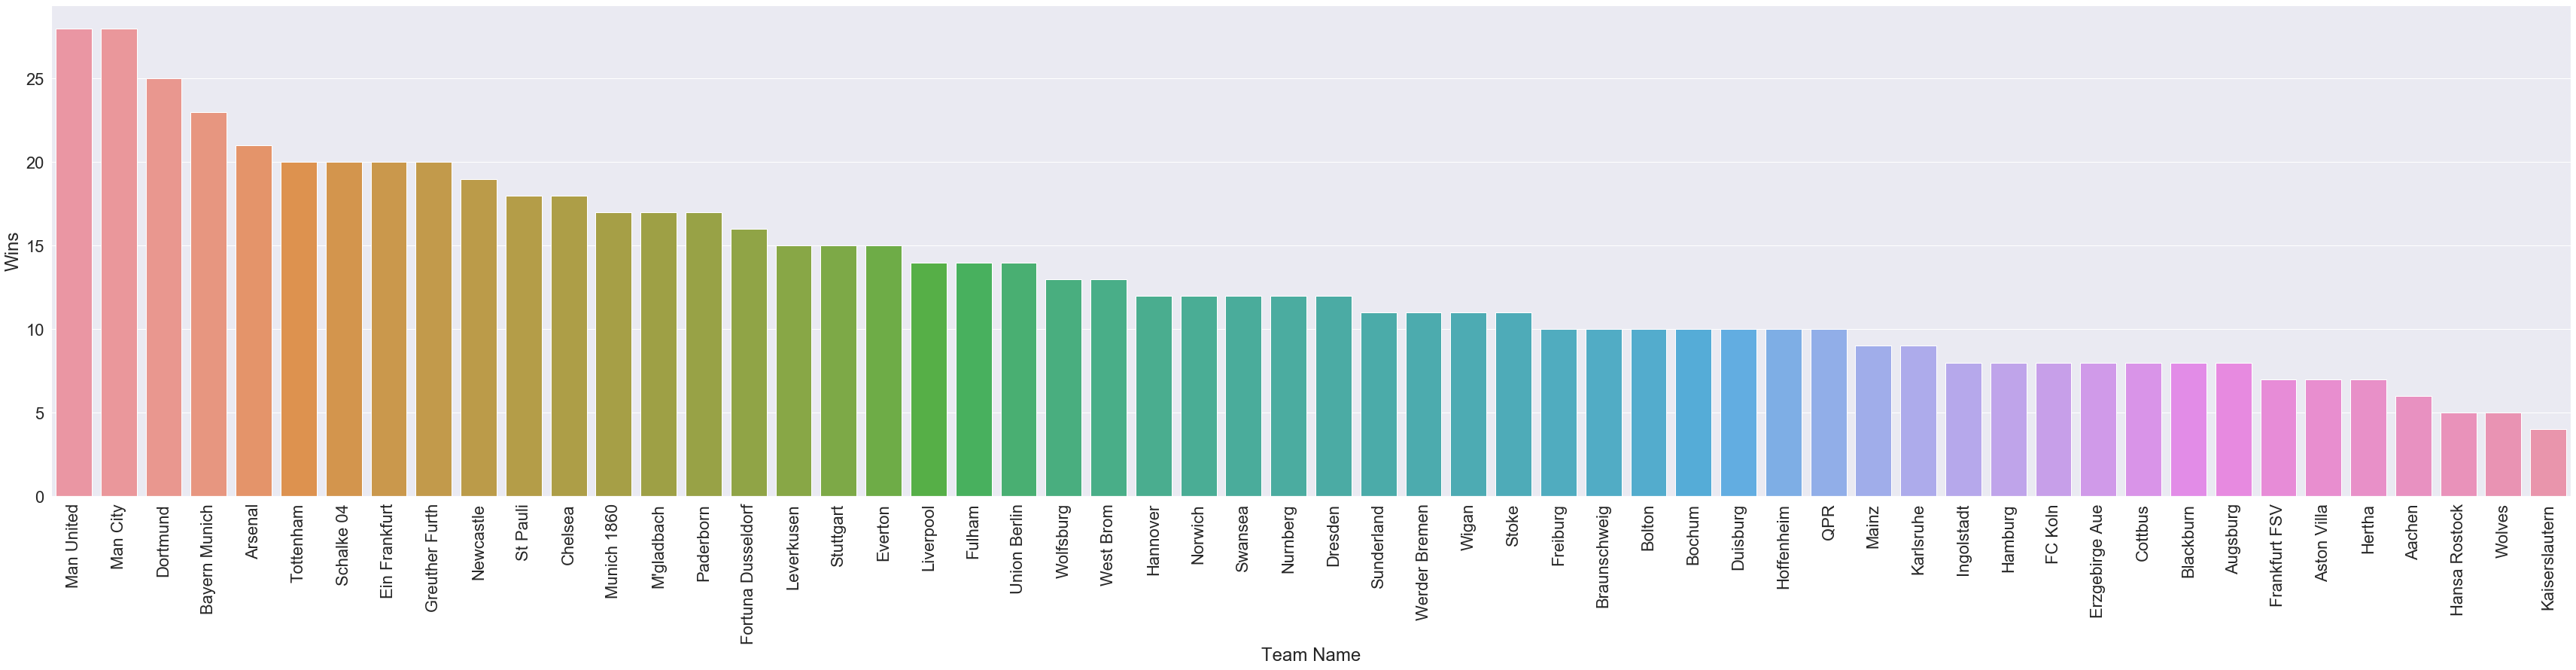

In [138]:
fig, ax = plt.subplots()
fig.set_size_inches(60,12)
ax = sns.barplot(x="TeamName", y="Wins", ci=None, data=win_loss_goals.sort_values("Wins", ascending = False))
ax.set(xlabel='Team Name', ylabel='Wins')
plt.xticks(rotation=90)
sns.set(style='darkgrid', font_scale=2)
plt.show()

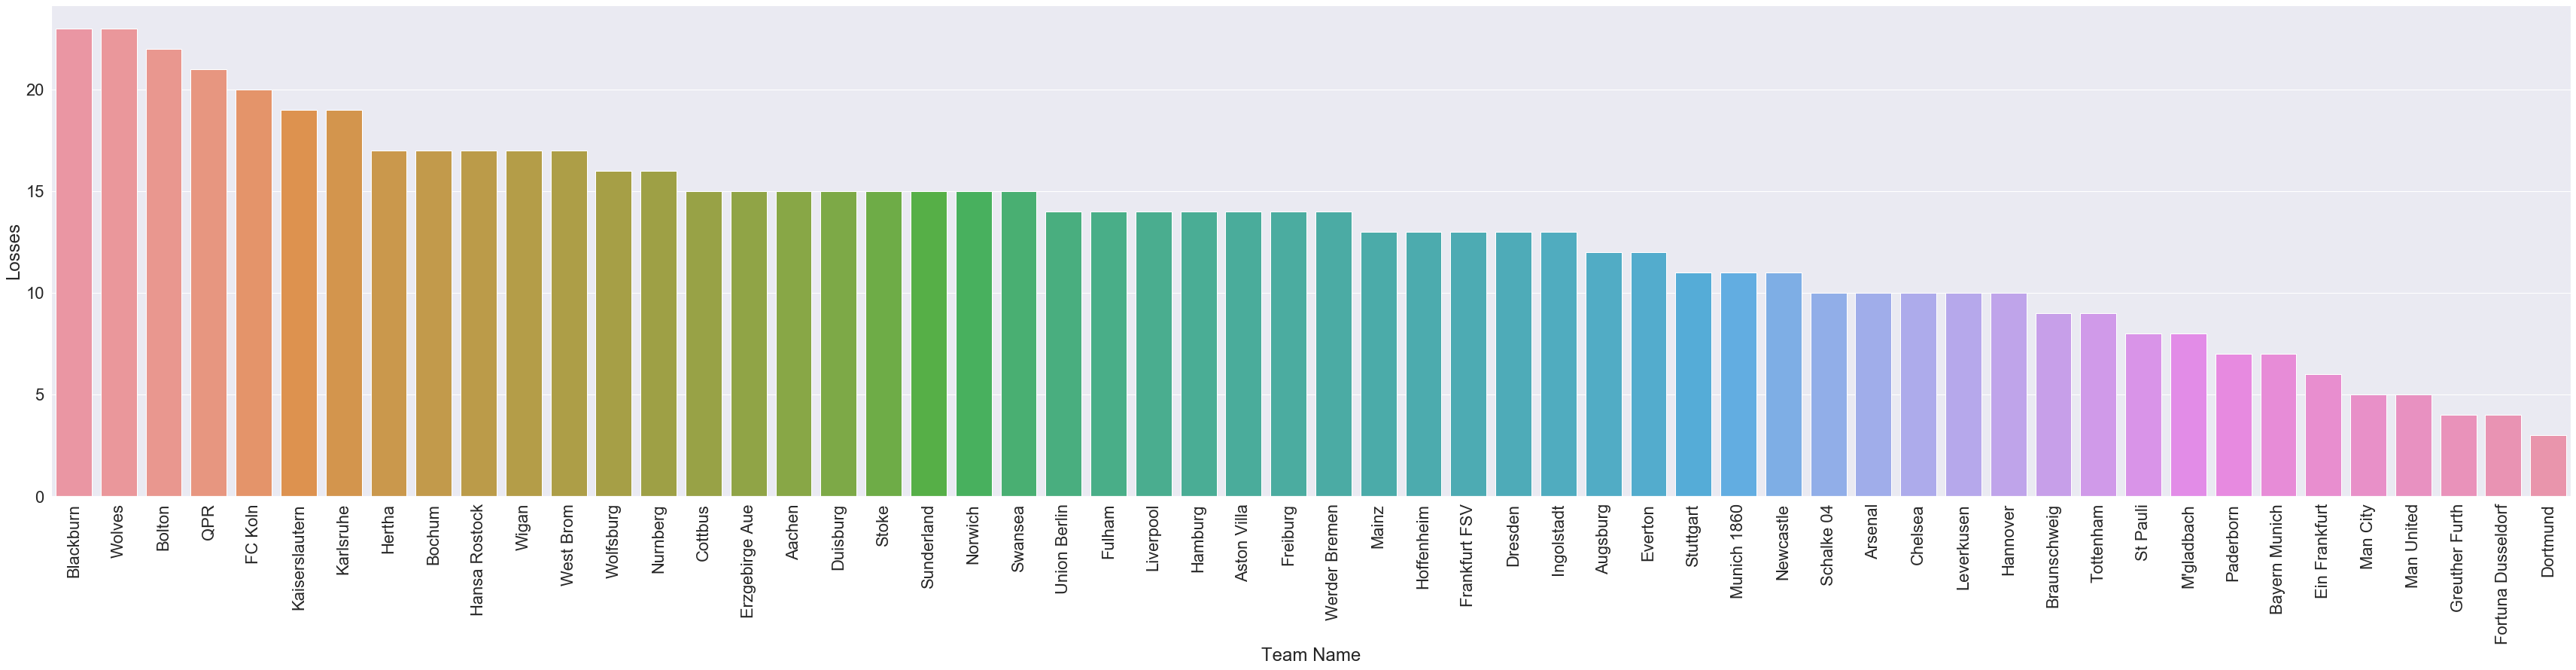

In [140]:
fig, ax = plt.subplots()
fig.set_size_inches(60,12)
ax = sns.barplot(x="TeamName", y="Losses", ci=None, data=win_loss_goals.sort_values("Losses", ascending = False))
ax.set(xlabel='Team Name', ylabel='Losses')
plt.xticks(rotation=90)
sns.set(style='darkgrid', font_scale=2)
plt.show()

In [ ]:
key = 'fb0f9ed1a7256224f761c32eb7071c0e' # darians API key
latitude = 52.5200 #lat of berlin
longitude = 13.4050 # lon of berlin
time = [] # variable for each match
for weather in darksky:
    requests.get(f"https://api.darksky.net/forecast/{key}/{latitude},{longitude},{time}")
group by date instead of each match